In [3]:
## HIDDEN MARKOV MODEL FOR FACE RECOGNITION IN LFS DATASET
import os
from time import time
import errno
import shutil
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import GridSearchCV
import seaborn as sns

import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [4]:
data_path = "./data/"

# LFS dataset from path
lfw = fetch_lfw_people(min_faces_per_person=70, resize=0.4, data_home=data_path)


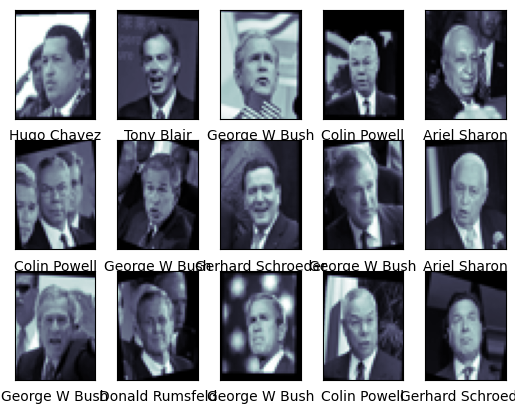

In [5]:
## visualize the data
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(lfw.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=lfw.target_names[lfw.target[i]])

In [6]:
lfw_people = lfw.copy()

In [7]:
lfw_people.keys()

dict_keys(['data', 'images', 'target', 'target_names', 'DESCR'])

In [8]:
# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people['images'].shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people['data']
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people['target']
target_names = lfw_people['target_names']
n_classes = lfw_people['target_names'].shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [9]:
#  split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25)

In [10]:
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled  
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

print("Extracting the top %d eigenfaces from %d faces"
        % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
            whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))

Extracting the top 150 eigenfaces from 966 faces
done in 0.421s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.016s


In [11]:
# Train a HMM using the best model found by grid search
print("Fitting the classifier to the training set")

from hmmlearn.hmm import GaussianHMM
hmm = GaussianHMM(n_components=4, covariance_type="diag", n_iter=1000).fit(X_train_pca)



Fitting the classifier to the training set


In [12]:
# Quantitative evaluation of the model quality on the test set
print("Predicting people's names on the test set")
t0 = time()
y_pred = hmm.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

Predicting people's names on the test set
done in 0.008s
                   precision    recall  f1-score   support

     Ariel Sharon       0.05      0.19      0.08        21
     Colin Powell       0.17      0.25      0.20        57
  Donald Rumsfeld       0.08      0.48      0.14        29
    George W Bush       0.00      0.00      0.00       136
Gerhard Schroeder       0.00      0.00      0.00        26
      Hugo Chavez       0.00      0.00      0.00        16
       Tony Blair       0.00      0.00      0.00        37

         accuracy                           0.10       322
        macro avg       0.04      0.13      0.06       322
     weighted avg       0.04      0.10      0.05       322

[[ 4  6 11  0  0  0  0]
 [ 9 14 34  0  0  0  0]
 [ 5 10 14  0  0  0  0]
 [30 35 71  0  0  0  0]
 [ 8  8 10  0  0  0  0]
 [ 3  5  8  0  0  0  0]
 [15  3 19  0  0  0  0]]


In [13]:
# Qualitative evaluation of the predictions using matplotlib
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

# plot the result of the prediction on a portion of the test set
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s, ground truth: %s' % (pred_name, true_name)

Predicted names:


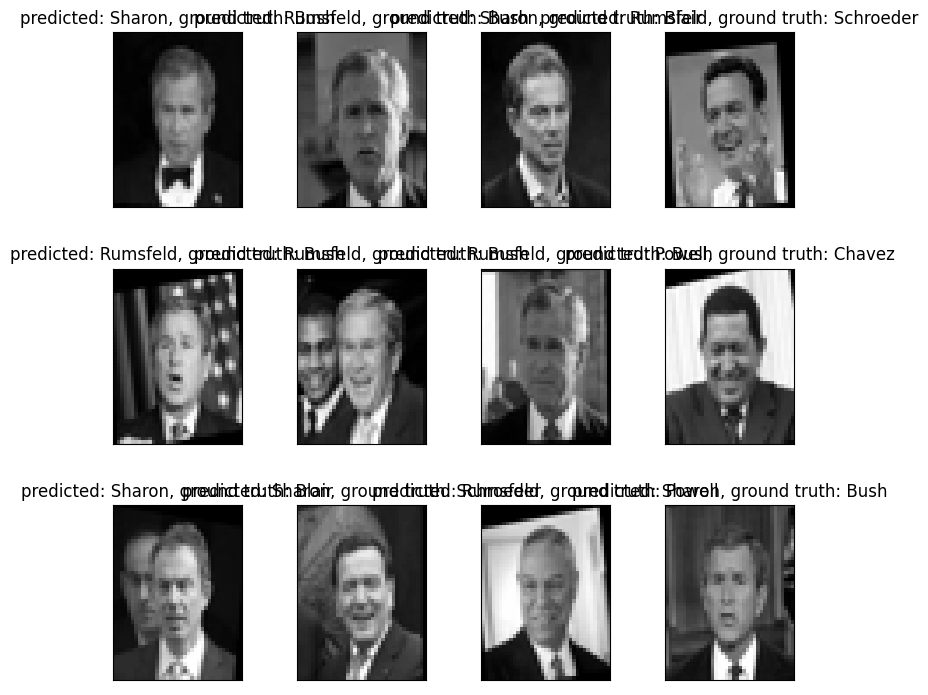

Eigenfaces:


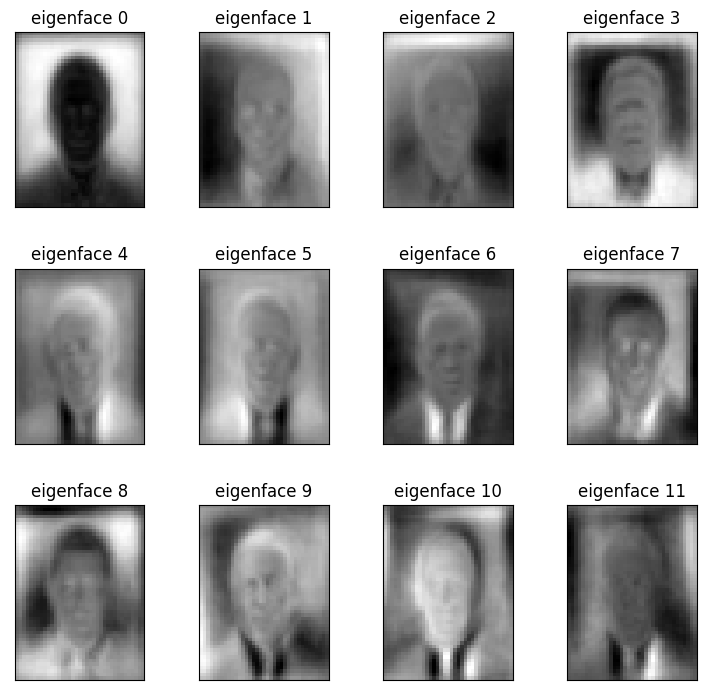

In [14]:
prediction_titles = [title(y_pred, y_test, target_names, i)
                        for i in range(y_pred.shape[0])]

print("Predicted names:")
plot_gallery(X_test, prediction_titles, h, w)
plt.show()

# plot the gallery of the most significative eigenfaces
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
print("Eigenfaces:")
plot_gallery(eigenfaces, eigenface_titles, h, w)
plt.show()